In [1]:
import time
import gc
import numpy as np
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark import SparkConf, SparkContext

if 'sc' not in locals():
    sc = SparkContext()

In [2]:
# Make the DataFrame
sqlContext = SQLContext(sc)
sdf = sqlContext.read.format('csv').options(header='true').load('training_test_data.txt')


tokenizer = Tokenizer(inputCol="body", outputCol="words")
tokenized_sdf = tokenizer.transform(sdf)
start = time.clock()
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
featurized_sdf = hashingTF.transform(tokenized_sdf)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurized_sdf)
final = idfModel.transform(featurized_sdf).select("topic", "features")
end = time.clock()
pyspark_duration = end - start
print(pyspark_duration)
final = final.select(col("topic").alias("label"), col("features").alias("features"))

0.01290099999999983


In [3]:
final.show()

+------+--------------------+
| label|            features|
+------+--------------------+
| grain|(262144,[1846,328...|
| wheat|(262144,[9639,158...|
|coffee|(262144,[4081,508...|
| sugar|(262144,[353,2366...|
| trade|(262144,[3283,380...|
|  ship|(262144,[1846,963...|
| grain|(262144,[9639,101...|
|  ship|(262144,[444,2776...|
|coffee|(262144,[9677,154...|
| grain|(262144,[4737,963...|
| sugar|(262144,[227,2366...|
| grain|(262144,[27570,28...|
| grain|(262144,[2410,328...|
| crude|(262144,[4900,910...|
| grain|(262144,[5213,963...|
| crude|(262144,[7838,967...|
|   cpi|(262144,[733,1846...|
| grain|(262144,[640,4842...|
| crude|(262144,[5381,910...|
| grain|(262144,[5381,678...|
+------+--------------------+
only showing top 20 rows



In [4]:
from pyspark.ml.feature import StringIndexer

In [5]:
indexer = StringIndexer(inputCol="label", outputCol="indexed")
final = indexer.fit(final).transform(final)
final.drop('label').collect()
final = final.select(col("indexed").alias("label"), col("features").alias("features"))
final.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[1846,328...|
| 15.0|(262144,[9639,158...|
|  6.0|(262144,[4081,508...|
|  5.0|(262144,[353,2366...|
|  2.0|(262144,[3283,380...|
|  4.0|(262144,[1846,963...|
|  0.0|(262144,[9639,101...|
|  4.0|(262144,[444,2776...|
|  6.0|(262144,[9677,154...|
|  0.0|(262144,[4737,963...|
|  5.0|(262144,[227,2366...|
|  0.0|(262144,[27570,28...|
|  0.0|(262144,[2410,328...|
|  1.0|(262144,[4900,910...|
|  0.0|(262144,[5213,963...|
|  1.0|(262144,[7838,967...|
| 10.0|(262144,[733,1846...|
|  0.0|(262144,[640,4842...|
|  1.0|(262144,[5381,910...|
|  0.0|(262144,[5381,678...|
+-----+--------------------+
only showing top 20 rows



In [6]:
if 'sdf' in locals():
    del sdf

if 'tokenized_sdf' in locals():
    del tokenized_sdf

if 'featurized_sdf' in locals():
    del featurized_sdf
gc.collect()
final

DataFrame[label: double, features: vector]

In [7]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [8]:
data, validate = final.randomSplit([.9, .1])

In [9]:
splits = [
    [0.55555, 0.44445],
    [0.66666, 0.33334],
    [0.77777, 0.22223],
]
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
models = {i: [] for i in range(3)}
accs = {i: [] for i in range(3)}
for s, split in enumerate(splits):
    for i in range(10):
        train, test = data.randomSplit(split)
        model = nb.fit(train)
        predictions = model.transform(test)
        # print(predictions.head().prediction)
        accuracy = evaluator.evaluate(predictions)
        print(accuracy)
        accs[s].append(accuracy)
        # models[s].append(model)
    print("AVG: {}".format(np.mean(accs[s])))

0.6953441295546559
0.6929375639713409
0.697841726618705
0.6859421734795613
0.6985365853658536
0.7099697885196374
0.6751893939393939
0.6705539358600583
0.7173252279635258
0.7018572825024438
AVG: 0.6945497807775177
0.6823056300268097
0.7064220183486238
0.7202216066481995
0.7191780821917808
0.6934210526315789
0.68717277486911
0.7124183006535948
0.7203728362183754
0.7188703465982028
0.7188755020080321
AVG: 0.7079258150194307
0.7225433526011561
0.7406015037593985
0.731610337972167
0.7351778656126482
0.7131630648330058
0.7196078431372549
0.7641509433962265
0.7125506072874493
0.7170172084130019
0.707635009310987
AVG: 0.7264057736323296


In [10]:
import matplotlib.pyplot as plt

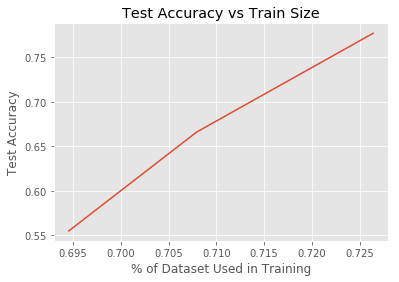

In [15]:
plt.style.use('ggplot')
plt.plot([np.mean(accs[i]) for i in accs], [0.555, 0.666, 0.777])
plt.title("Test Accuracy vs Train Size")
plt.ylabel("Test Accuracy")
plt.xlabel("% of Dataset Used in Training")
plt.show()

In [ ]:
train_percentage = [i / 20 for i in range(1,20)]

splits = [[i, 1-i] for i in train_percentage]
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
models = {i: [] for i in range(len(splits))}
accs = {i: [] for i in range(len(splits))}
for s, split in enumerate(splits):
    for i in range(2):
        train, test = data.randomSplit(split)
        model = nb.fit(train)
        predictions = model.transform(test)
        # print(predictions.head().prediction)
        accuracy = evaluator.evaluate(predictions)
        print(accuracy)
        accs[s].append(accuracy)
        # models[s].append(model)
    print("AVG: {}".format(np.mean(accs[s])))

0.6096879366557988
0.5592747559274756
AVG: 0.5844813462916372
0.5898931000971818
0.634936211972522
AVG: 0.6124146560348519
0.6111397627643115
0.6287332646755922
AVG: 0.6199365137199518
0.6557830658550083
0.5839295542102366
AVG: 0.6198563100326224
0.6403712296983759
0.6832445233866193
AVG: 0.6618078765424976
0.6829573934837093
0.66729205753596
AVG: 0.6751247255098347
0.6691474966170501
0.6595030221625252
AVG: 0.6643252593897877
0.6639526276831976
0.7268041237113402
AVG: 0.6953783756972689
0.6905901116427432
0.6903633491311216
AVG: 0.6904767303869324
0.7102076124567474
0.6905594405594405
AVG: 0.700383526508094
0.6808309726156752
0.7142857142857143
AVG: 0.6975583434506947
0.6716577540106952
0.7183718371837183
AVG: 0.6950147955972068
0.681045751633987
0.7157622739018088
AVG: 0.6984040127678979
0.6986706056129985
0.7114285714285714
AVG: 0.705049588520785
0.7340619307832422
0.7442748091603053
AVG: 0.7391683699717737
0.6634844868735084
0.7418655097613883
AVG: 0.7026749983174483
0.722891566265

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ConnectionRefusedError: [Errno 61] Connection refused
--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

--- Logging error ---
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/

ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:51672)
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, sel

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-07498882a815>", line 11, in <module>
    model = nb.fit(train)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/base.py", line 64, in fit
    return self._fit(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 265, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark/ml/wrapper.py", line 262, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/py4j/java_gateway.py", line 1160, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/bin/anaconda3/lib/python3.5/site-packages/pyspark

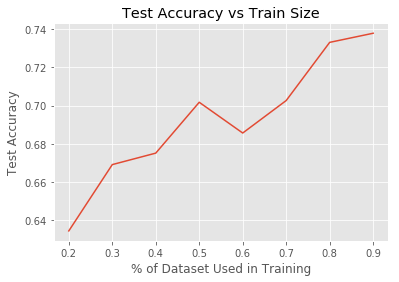

In [21]:
plt.style.use('ggplot')
plt.plot([p[0] for p in splits], [np.mean(accs[i]) for i in accs])
plt.title("Test Accuracy vs Train Size")
plt.ylabel("Test Accuracy")
plt.xlabel("% of Dataset Used in Training")
plt.show()